### Import Libraries

In [1]:
# Add libraries freely, if you need.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
import cv2 as cv
from cv2 import * 

import os
import fastai
import torch

### Version Checking

In [3]:
cv.__version__

'4.5.5'

In [4]:
print(torch.__version__)

1.11.0


In [5]:
print(fastai.__version__)

1.0.61


### Local GPU Setting

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'device name: {torch.cuda.get_device_name(0)}')

Using cuda device
device name: NVIDIA GeForce RTX 3060 Laptop GPU


-------------------------------------------------------------------------------------------

### Function Define

In [8]:
# train, valid, test 구조로 분할하는 함수
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))        # 반환된 입력 경로 내의 모든 파일과 폴더의 갯수 파악 
    full_set = list(range(1,n+1))      # 반환된 입력 경로 내의 모든 파일과 폴더의 갯수에 대응되는 List index 생성.
                                       # 만약, 폴더 내에 5개의 파일이 존재했다면   full_set = [1,2,3,4,5] 가 될 것이다.


    # train 인덱싱(=Train Data로 사용할 데이터의 번호를 뽑아오는 과정)
    random.seed(seed1)                 # 시드를 고정시켜서 난수값이 동일하게 유지될 수 있도록 한다.
                                       # 즉, random.seed()    로 실항해면 매번 실행할 때마다 난수값이 바뀌지만
                                       #     random.seed(100) 이와 같이 시드를 고정시키면 처음 생성된 난수 값이 다음에 random.seed(100)이렇게 호출하여도 동일한 값이 나온다.
    train = random.sample(list(range(1,n+1)), int(.8*n))   # random.sample(seq, k)  임의로 선택하거나, 뒤섞거나, 샘플링하는 코드.
                                                           # sequence: 리스트, 집합, range() 등 random의 범위가 될 sequence 입력
                                                           # k:        반환될 리스트의 크기 입력
                                                           # 전체에서 80%의 Dataset을 train data로 indexing한다. 
    remain = list(set(full_set)-set(train))   # 변수 타입을 'set' 집합 형태로 바꾸어 빼기 연산을 수행한 뒤에 다시 List Type으로 반환
                                              # Set Type = 순서가 없고 중복이 허용되지 않는 집합


    # valid 인덱싱(=Validation Data로 사용할 데이터의 번호를 뽑아오는 과정)
    # test 인덱싱(=Test Data로 사용할 데이터의 번호를 뽑아오는 과정)
    random.seed(seed2)
    valid = random.sample(remain, int(len(remain)))        # 전체에서 Train을 빼고 남은 20%를 valid data로 indexing한다. 
    
    return(train,valid)

In [9]:
# 인덱싱에 따라 파일 이름을 구하기   -> split_indices 함수를 통해 Train/Validation/Test의 Index를 구했다면,
#                                       get_names     함수를 통해 Train/Validation/Test로 사용할 이미지의 Full Name을 모두 뽑아서 저장해준다.
#                                   즉, waste_type 에는 List형태의 ['plastic', 'metal', ''paper' ...] 이 입력으로 들어갈 것이며
#                                   즉, indices    에는 List형태의 [1, 3, 7, 20, 56, ...] 인덱스 번호가 입력으로 들어갈 것이다.
def get_names(waste_type, indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)

In [10]:
# 파일의 위치를 옮기는 함수          -> move_files 함수를 통해 destination_folder 에 Train/Validation/Test Data로 사용할 Image Data들을 하나하나 for문을 통해 옮겨주도록 한다.
def move_files(source_files, destination_folder):
    for file in source_files:
        shutil.move(file, destination_folder)

In [11]:
# 지정해준 경로의 폴더 안에 존재하는 모든 파일 삭제하는 함수 정의
def DeleteAllFiles(filePath):
    if os.path.exists(filePath):
        for file in os.scandir(filePath):
            os.remove(file.path)
        return 'Remove All File'
    else:
        return 'Directory Not Found'

***

### Data Loading & Unzip Kaggle Dataset

In [12]:
# zip 파일의 모든 파일과 폴더를 현재 작업 디렉터리로 압축 해제
import zipfile as zf

files = zf.ZipFile("dataset_fit.zip", 'r')   # 압축 해체/생성 할 File 지정
files.extractall()                           # 압축 해체/생성 진행! 만약, 특정 위치에 압축을 진행하고 싶다면 files.extractall("/content/driver/MyDrive/") 이런식으로 작성하면 된다.       
files.close()                                # 압축 해제/생성 종료 후, 파일 닫기까지 진행

In [13]:
# 압축 파일 내의 모든 파일과 폴더명 리스트 반환
import os
os.getcwd()                                            # os.getcwd()    : 현재 작업 디렉토리 확인
os.path.join(os.getcwd(), "dataset_fit")               # os.path.join() : 파일명과 경로를 합치기
os.listdir(os.path.join(os.getcwd(), "dataset_fit"))   # os.listdir()   : 입력 경로 내의 모든 파일과 폴더명 리스트 반환

['cardboard', 'metal', 'plastic']

***

### Split Train/Validation Data

In [15]:
import random
import shutil

# 데이터 종류 / 쓰레기 타입 설정
subsets     = ['train','valid']
waste_types = ['cardboard', 'metal', 'plastic']


# data/데이터 종류/쓰레기 타입 디렉토리가 존재하지 않으면 폴더를 생성한다.
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data', subset, waste_type)   # os.path.join() : 파일명과 경로를 합치기
                                                            # 즉,   data/train/metal   data/train/plastic   data/valid/metal 등의 경로를 여기서 지정하고 folder라는 변수에 해당 경로를 저장한다.

        if not os.path.exists(folder):                      # 만약, folder에 저장된 경로와 동일한 경로가 존재하지 않는다면
            os.makedirs(folder)                             # os.makedirs(folder) 함수를 통해, folder에 저장된 경로를 똑같이 만들어 준다!
                                                            # os.makedirs(folder) 함수는 './a/b/c' 처럼 원하는 만큼 디렉토리를 생성할 수 있는 것이 큰 장점이다.



# Test를 할때는 임의의 data에 대해 해당 data가 plastic인지, metal인지를 구분해야 하기 때문에 test data에 대해서는 쓰레기 타입 폴더를 따로 지정하지 않아야 한다.
# 즉, Test폴더는 쓰레기 타입 디렉토리가 포함되지 않으므로 다음과 같이 폴더를 따로 생성해준다.
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))

if not os.path.exists(os.path.join('data','test_realtime')):
    os.makedirs(os.path.join('data','test_realtime'))

    
# 이 코드를 실행하면 작업창에 data/train/metal 등과 같은 빈 폴더들이 생겨있음을 확인할 수 있다.

In [16]:
# 각 쓰레기 타입별로 
for waste_type in waste_types:
    source_folder = os.path.join('dataset_fit', waste_type)              # os.path.join() : 파일명과 경로를 합치기
    train_ind, valid_ind = split_indices(source_folder,1,1)              # seed는 seed1과 seed2 모두 '1'로 고정하였으며, 이 코드를 통해서 train/valid/test 로 사용할 index를 waste_type에 따라서 각각 가져온다.
                                                                         # 즉, plastic 에 대해서 train/valid/test 로 사용할 index
                                                                         #     metal   에 대해서 train/valid/test 로 사용할 index 등 각각 가져오는 것!

    # 파일들을 train 폴더로 옮김
    train_names = get_names(waste_type,train_ind)                                   # Train Data로 사용할 사진들의 Full Name을 waste_type에 따라서 각각 가져온다.
    train_source_files = [os.path.join(source_folder,name) for name in train_names] # Train Data로 사용할 사진들의 경로를 waste_type에 따라서 각각 가져온다.
    move_files(train_source_files, "data/train/" + waste_type)                      # Train Data로 사용할 사진들을 종류에 맞게 "data/train/plastic"  "data/train/metal"  "data/train/cardboard"로 각각 옮겨 준다.
    
    # 파일들을 valid 폴더로 옮김
    valid_names = get_names(waste_type,valid_ind)                                   # Valid Data로 사용할 사진들의 Full Name을 waste_type에 따라서 각각 가져온다.
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names] # Valid Data로 사용할 사진들의 경로를 waste_type에 따라서 각각 가져온다.
    move_files(valid_source_files, "data/valid/" + waste_type)                      # Valid Data로 사용할 사진들을 종류에 맞게 "data/valid/plastic"  "data/valid/metal"  "data/valid/cardboard"로 각각 옮겨 준다.

In [17]:
# Fastai Library Import :: Fastai는 PyTorch를 기반으로 한 딥러닝 라이브러리
from fastai.vision import *
  
path = Path(os.getcwd())      # dir = Path(dir_name)
path = path/"data"            # file = dir / sub_dir_name / file_name     즉, '/'를 통해 파일을 하나하나 들어갈 수 있다.
path

WindowsPath('C:/Users/sehye/source/repos/GitHub_DeskTop/2022-1_DTA_Garbage_Classification/2. Three_Class_Garbage_Classification/data')

### Folder Clearing & Test Image Define and Resize

In [18]:
# data/test 폴더 안에 존재하는 모든 파일 삭제
print(DeleteAllFiles('data/test'))

Remove All File


In [19]:
file_list     = os.listdir('Random_Test_Image')   # Input_Image 폴더 내 모든 파일 이름 가져오기


# 습득한 이미지 데이터를 학습할 수 있는 크기의 이미로 Resize하는 과정
# Random_Test_Image 폴더에 존재하는 모든 사진을 Resize한 뒤에 data/test 폴더에 저장해준다.
for file in file_list:
    src = cv.imread('Random_Test_Image/' + file)
    dst = cv.resize(src, dsize=(512, 384), interpolation=cv.INTER_AREA)
    
    cv.imwrite('data/test/' + file, dst)

### Data Transform

In [20]:
# Fastai의 get_transforms 함수 :: 데이터를 좌우로 반전시키거나 밝기를 조절한다던가 회전시킨다던가 등의 역할을 하며 이를 통해 하나의 이미지 데이터라도 다양하고 복잡하게 학습할 수 있다.
# Fastai의 get_transforms 함수 :: Hyper-Parameter 설명
#       do_flip   : if True the image is randomly flipped (default behavior)
#       flip_vert : limit the flips to horizontal flips (when False) or to horizontal and vertical flips as well as 90-degrees rotations (when True)
tfms = get_transforms(do_flip=True, flip_vert=True)

In [21]:
# Fastai의 ImageDataBunch 함수 :: If you quickly want to get a ImageDataBunch and train a model, you should process your data to have it in one of the formats the following functions handle.
#                                 즉, ImageDataBunch를 통해 데이터를 빨리 생성하고 모델 Training을 하고 싶다면, ImageDataBunch.from_folder라는 형식을 사용하는 것이 좋다는 의미!
# Fastai의 ImageDataBunch 함수 :: ImageDataBunch.from_folder 함수의 Hyper-Parameter 설명
#       path      : 경로 지정
#       Train     : 'path'를 통해 지정된 경로의 하위 Train dataset의 폴더명 지정
#       Valid     : 'path'를 통해 지정된 경로의 하위 Valid dataset의 폴더명 지정
#       Test      : 'path'를 통해 지정된 경로의 하위 Test dataset의 폴더명 지정
#       ds_tfms   : 데이터셋 변형 형식 지정
#       bs        : 배치사이즈 지정
# data = ImageDataBunch.from_folder(path, train="train", valid="valid", test="test", ds_tfms=tfms, bs=16)
data = ImageDataBunch.from_folder(path, test="test", ds_tfms=tfms, bs=16)
data



# (+) Fastai Library 설명   ::   https://www.lhsz.xyz/read/fastai-1.x-en/9eaf33da32ab238a.md

# (+) LabelList가 Train, Valid, Test로 생성된 것을 확인할 수 있다.

ImageDataBunch;

Train: LabelList (1035 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Users\sehye\source\repos\GitHub_DeskTop\2022-1_DTA_Garbage_Classification\2. Three_Class_Garbage_Classification\data;

Valid: LabelList (260 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Users\sehye\source\repos\GitHub_DeskTop\2022-1_DTA_Garbage_Classification\2. Three_Class_Garbage_Classification\data;

Test: LabelList (10 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: C:\Users\sehye\source\repos\GitHub_DeskTop\2022-1_DTA_Garbage_Classification\2. Three_Class_Garbage_Classification\data

### Model Training

In [22]:
# learn.model
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [23]:
# 모델 학습시키기!
learn.fit_one_cycle(15, max_lr=1e-02)

epoch,train_loss,valid_loss,error_rate,time
0,0.641238,0.267046,0.080769,01:23
1,0.520838,0.406387,0.130769,01:22
2,0.535828,0.774689,0.153846,01:21
3,0.594523,0.251400,0.092308,01:20
4,0.554452,0.327242,0.100000,01:23
5,0.541785,0.221818,0.065385,01:19
6,0.423337,0.350584,0.126923,01:21
7,0.384242,0.197222,0.080769,01:21
8,0.364846,0.194756,0.046154,01:24
9,0.260186,0.153461,0.053846,01:20


### Train Result

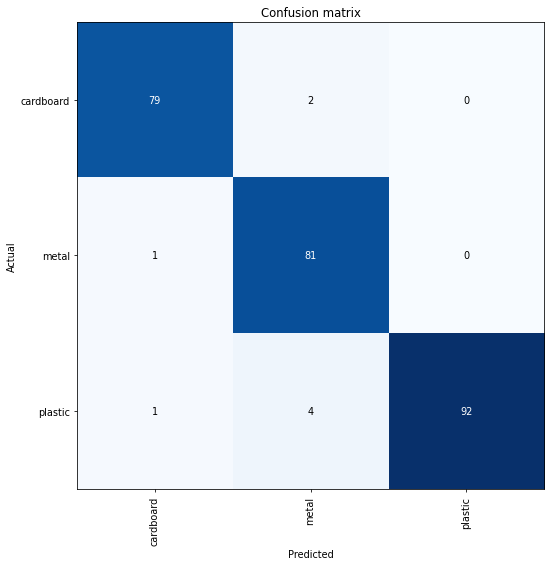

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=70)   # dpi	= dots per inch = Matrix 한칸한칸의 크기 지정

***

### Apply Model to Test Data

In [25]:
# Testset 예측 결과 확인해보기 - get_preds 함수 이용!
preds = learn.get_preds(ds_type=DatasetType.Test)   # ds_type 에 지정해준 데이터에 대한 예측 결과를 반환.
print(preds[0].shape)
print(preds[0])

torch.Size([10, 3])
tensor([[6.0675e-01, 3.7148e-01, 2.1765e-02],
        [7.5162e-01, 2.3913e-01, 9.2442e-03],
        [9.8742e-01, 1.2263e-02, 3.2014e-04],
        [1.7267e-02, 9.6661e-01, 1.6120e-02],
        [3.8980e-03, 9.9020e-01, 5.9025e-03],
        [1.1618e-01, 1.6239e-06, 8.8382e-01],
        [1.3377e-04, 2.7481e-04, 9.9959e-01],
        [1.0566e-02, 4.2918e-06, 9.8943e-01],
        [2.6577e-03, 1.5584e-04, 9.9719e-01],
        [2.6026e-02, 3.1852e-04, 9.7366e-01]])


In [26]:
max_idxs = np.argmax(preds[0],axis=1)
max_idxs = np.asarray(max_idxs)
max_idxs

array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2], dtype=int64)

In [27]:
# 부여된 번호를 토대로 class의 이름을 부여
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])
print(yhat)

['cardboard', 'cardboard', 'cardboard', 'metal', 'metal', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic']


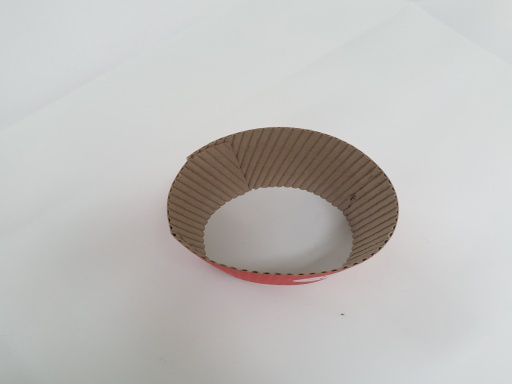

In [28]:
# 첫번째 test 데이터의 이미지 확인 :: 첫번째 인덱스는 image번호, 두번째 인덱스는 [0]일때 이미지 출력, [1]일때 class 출력
learn.data.test_ds[0][0]

In [29]:
y = []

# 각 이미지 파일의 경로를 저장
for label_path in learn.data.test_ds.items:
    y.append(str(label_path))

y

['C:\\Users\\sehye\\source\\repos\\GitHub_DeskTop\\2022-1_DTA_Garbage_Classification\\2. Three_Class_Garbage_Classification\\data\\test\\cardboard1.jpg',
 'C:\\Users\\sehye\\source\\repos\\GitHub_DeskTop\\2022-1_DTA_Garbage_Classification\\2. Three_Class_Garbage_Classification\\data\\test\\cardboard2.jpg',
 'C:\\Users\\sehye\\source\\repos\\GitHub_DeskTop\\2022-1_DTA_Garbage_Classification\\2. Three_Class_Garbage_Classification\\data\\test\\cardboard3.jpg',
 'C:\\Users\\sehye\\source\\repos\\GitHub_DeskTop\\2022-1_DTA_Garbage_Classification\\2. Three_Class_Garbage_Classification\\data\\test\\metal1.jpg',
 'C:\\Users\\sehye\\source\\repos\\GitHub_DeskTop\\2022-1_DTA_Garbage_Classification\\2. Three_Class_Garbage_Classification\\data\\test\\metal2.jpg',
 'C:\\Users\\sehye\\source\\repos\\GitHub_DeskTop\\2022-1_DTA_Garbage_Classification\\2. Three_Class_Garbage_Classification\\data\\test\\plastic1.jpg',
 'C:\\Users\\sehye\\source\\repos\\GitHub_DeskTop\\2022-1_DTA_Garbage_Classification\\

In [30]:
# 파일 이름을 통해 정답값을 추출.
pattern = re.compile("([a-z]+)([0-9]+)")   # 메타 문자로 패턴 입력
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)
    
print(y)

['cardboard', 'cardboard', 'cardboard', 'metal', 'metal', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic']


### Test Data Result

In [31]:
# 예측값
print(yhat[0:5])
# 실제값
print(y[0:5])

['cardboard', 'cardboard', 'cardboard', 'metal', 'metal']
['cardboard', 'cardboard', 'cardboard', 'metal', 'metal']


[[3 0 0]
 [0 2 0]
 [0 0 5]]


<AxesSubplot:>

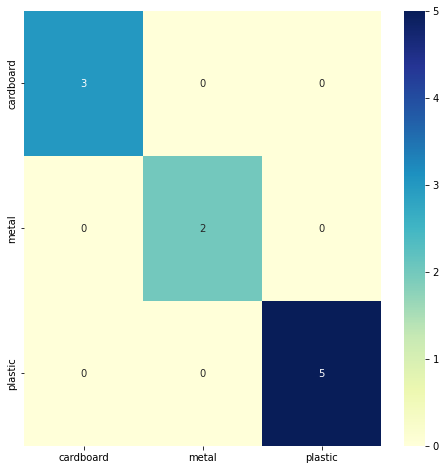

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, yhat)
print(cm)

import seaborn as sns
df_cm = pd.DataFrame(cm, waste_types, waste_types)

plt.figure(figsize=(8,8))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")

In [33]:
correct = 0

for i in range(len(yhat)) :
    if y[i] == yhat[i] :
        correct += 1

accuracy = correct / len(yhat)
accuracy

1.0

### Model Save

In [34]:
# 모델 이름 정의
model_file_name = 'garbage_classification_model'
    
# 모델 저장
learn.save(model_file_name, path)

# 모델 로드
# learn.load(model_file_name)

WindowsPath('C:/Users/sehye/source/repos/GitHub_DeskTop/2022-1_DTA_Garbage_Classification/2. Three_Class_Garbage_Classification/data/models/garbage_classification_model.pth')

***